# Probabilistic Matrix Factorization

## Factorization in Stock Analysis

In [14]:
# visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn

# core libraries
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import theano
import theano.tensor as tt

import multiprocessing

# Enable on-the-fly graph computations, but ignore absence of intermediate test values.
theano.config.compute_test_value = 'ignore'

DAYS_PER_YEAR = 250

returns_df = pd.read_csv('returns.csv')
returns_df.head()

,Date,RSP,QVAL,SYLD,BRK_A,IVAL,GVAL,FYLD,QMOM,GMOM,IMOM
0,2016-01-04 00:00:00+00:00,-0.011088,-0.004047,-0.016943,-0.007576,-0.007585,-0.011664,-0.011718,-0.031732,-0.010167,-0.013003
1,2016-01-05 00:00:00+00:00,0.001837,-0.000913,0.004255,0.001934,-0.009704,-0.003053,-0.005044,0.005691,0.003104,-0.003194
2,2016-01-06 00:00:00+00:00,-0.018301,-0.024857,-0.016480,0.003365,-0.022070,-0.017728,-0.014687,-0.011752,-0.001775,-0.017221
3,2016-01-07 00:00:00+00:00,-0.022392,-0.010121,-0.017815,-0.011251,-0.018267,-0.006236,-0.017028,-0.022859,-0.003556,-0.011410
4,2016-01-08 00:00:00+00:00,-0.011801,-0.032095,-0.016354,-0.008396,-0.004832,-0.007844,-0.004209,-0.017084,-0.003614,-0.000824


In [15]:
returns_df.drop(['Date'], axis=1, inplace=True)

In [16]:
returns_df.head()

,RSP,QVAL,SYLD,BRK_A,IVAL,GVAL,FYLD,QMOM,GMOM,IMOM
0,-0.011088,-0.004047,-0.016943,-0.007576,-0.007585,-0.011664,-0.011718,-0.031732,-0.010167,-0.013003
1,0.001837,-0.000913,0.004255,0.001934,-0.009704,-0.003053,-0.005044,0.005691,0.003104,-0.003194
2,-0.018301,-0.024857,-0.016480,0.003365,-0.022070,-0.017728,-0.014687,-0.011752,-0.001775,-0.017221
3,-0.022392,-0.010121,-0.017815,-0.011251,-0.018267,-0.006236,-0.017028,-0.022859,-0.003556,-0.011410
4,-0.011801,-0.032095,-0.016354,-0.008396,-0.004832,-0.007844,-0.004209,-0.017084,-0.003614,-0.000824


In [35]:
def plot_cov(data, trace, figsize=(12, 9), vmin=.05, vmax=.25):

    historical_cov_sqrt_df = (returns_df.cov() * DAYS_PER_YEAR) ** .5

    bayesian_cov_sqrt_df = pd.DataFrame(
        data    = (trace.get_values('cov').mean(axis=0) * DAYS_PER_YEAR) ** .5, 
        index   = data.columns,
        columns = data.columns
    )

    _, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(data=historical_cov_sqrt_df, vmin=vmin, vmax=vmax)
    ax.set_title('Historical Covariance')

    _, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(data=bayesian_cov_sqrt_df, vmin=vmin, vmax=vmax)
    ax.set_title('Bayesian Covariance')

    _, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(data=historical_cov_sqrt_df - bayesian_cov_sqrt_df)
    ax.set_title('Correlation Differences (Historical - Bayesian)')

In [32]:
def correlation(dataset, verbose=0, draws=10000, 
                target_accept=0.90, sample_init='advi', 
                cores=4):
    """
    Sampling Correlation with LKJ.
    
    The shape parameter (eta > 0) of the LKJ distribution. eta=1 implies a 
    uniform distribution of the correlation matrices; larger values put more weight 
    on matrices with few correlations.
    
    Note that we access the distribution for the standard deviations, 
    and do not create a new random variable.
    
    References
    --------------
        .. https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/LKJ.ipynb
        .. 
    """
    
    n_var = dataset.shape[1]

    with pm.Model() as model:
        mu = pm.Normal(
            name='mu',
            mu=0,
            sd=1,
            shape=n_var
        )
        
        packed_chol = pm.LKJCholeskyCov(
            name='chol_cov',
            n=n_var,
            eta=1,
            sd_dist=pm.HalfCauchy.dist(beta=2.5)
        )

        # Convert a packed triangular matrix into a two dimensional array.
        chol = pm.expand_packed_triangular(n=n_var, packed=packed_chol, lower=True)

        # Extract the standard deviations and correlations (rho)
        cov  = pm.Deterministic('cov', tt.dot(chol, chol.T))  # Compute the covariance matrix
        sd   = pm.Deterministic('sd', tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sd**-1).dot(cov.dot(tt.diag(sd**-1)))
        rho  = pm.Deterministic('rho', corr[np.triu_indices(n_var, k=1)])

        likelihood = pm.MvNormal(
            name='likelihood',
            mu=mu,
            chol=chol,
            observed=dataset
        )

        trace = pm.sample(
            draws            = draws // cores,
            init             = sample_init,
            n_init           = 150000,
            progressbar      = verbose > 0,
            cores            = cores,
            nuts_kwargs      = {'target_accept': target_accept},
        )

    if verbose > 0:
        pm.summary(trace=trace, varnames=['sd'])
        pm.traceplot(
            trace,
            varnames = ['sd'],
            combined = True
        )
        
    return model, trace

In [ ]:
correlation_model, correlation_trace = correlation(
    dataset   = returns_df,
    draws     = 50000,
    cores     = multiprocessing.cpu_count(),
    verbose   = 1
)

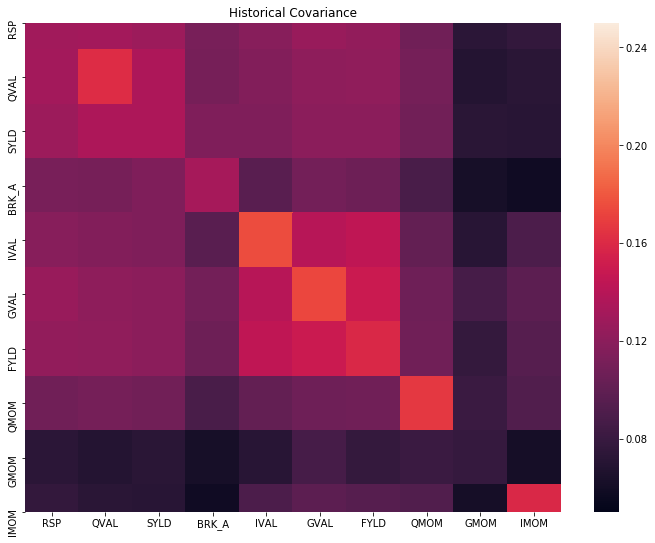

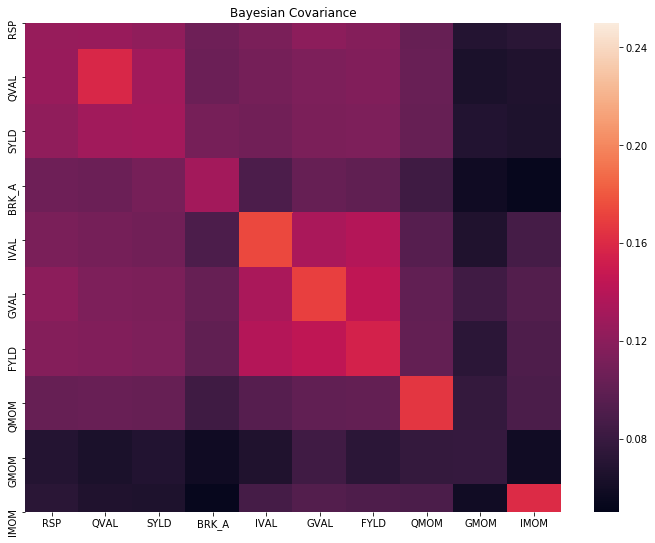

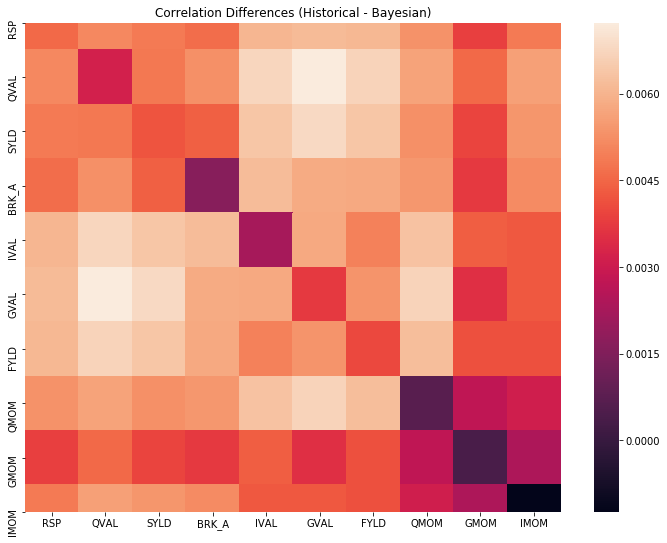

In [36]:
plot_cov(returns_df, correlation_trace)

Given:
- $M$: number of stocks
- $D$: number of factors
- $N$: length of time
- $R$: realized stock returns

Model:`
- $\underset{M\times D}{V} \sim \mathcal{N}\left ( 0, \sigma _{V} \right )$: factor weights
- $\underset{N\times D}{U} \sim \mathcal{N}\left ( 0, \sigma _{U} \right )$: factor returns
- $\underset{N\times M}{R} \sim \mathcal{N}\left ( UV^{T}, \sigma \right )$: stock returns

Having small $\sigma _{V}$ and $\sigma _{U}$ prevents overfitting, and is called complexity control.


In [37]:
def prob_factorization(dataset, n_factors=1, verbose=0, 
                       draws=50000, sample_init='advi', 
                       cores=4):
    """
    Probabilistic Matrix Factorization model.
    
    References
    --------------
        .. https://pymc-devs.github.io/pymc3/notebooks/pmf-pymc.html
        .. 
    """

    data        = dataset.values.copy()
    T, n_stocks = data.shape

    # Contruct PMF model
    with pm.Model() as model:
        # U        
        factor_returns_std = pm.HalfCauchy(
            name    = 'factor_returns_std',
            beta    = data.std(axis=1).mean(),
            testval = data.std(axis=1).mean()
        )

        factor_returns = pm.Normal(
            name    = 'factor_returns',
            mu      = 0,
            sd      = factor_returns_std,
            shape   = (T, n_factors),
            testval = np.random.randn(T, n_factors) * factor_returns_std
        )

        # V
        beta_std = pm.HalfCauchy(
            name    = 'beta_std',
            beta    = 1.0,
            testval = 1.0
        )

        beta_std = 1.0    
        beta = pm.Normal(
            name    = 'beta',
            mu      = 1.0,
            sd      = beta_std,
            shape   = (n_stocks, n_factors),
            testval = np.random.randn(n_stocks, n_factors) * beta_std
        )

        # R
        idiosyncratic_std = pm.HalfCauchy(
            name    = 'idiosyncratic_std',
            beta    = data.std(axis=1).mean(),
            shape   = n_stocks,
            testval = data.std(axis=1).mean()
        )

        stock_returns = pm.Normal(
            name     = 'stock_returns',
            mu       = tt.dot(factor_returns, beta.T),
            sd       = idiosyncratic_std,
            observed = data
        )

        cov = pm.Deterministic(
            name = 'cov',
            var  = factor_returns_std ** 2 * tt.dot(beta, beta.T) + (idiosyncratic_std ** 2) * np.eye(n_stocks)
        )

        stock_std = pm.Deterministic(
            name = 'stock_std',
            var  = tt.sqrt(tt.diag(cov))
        )

        trace = pm.sample(
            draws            = draws // cores,
            init             = sample_init,
            n_init           = 150000,
            progressbar      = verbose > 0,
            cores            = cores,
        )

    if verbose > 0:
        pm.summary(trace=trace, varnames=['stock_std', 'idiosyncratic_std', 'factor_returns_std'])
        pm.traceplot(
            trace,
            varnames = ['stock_std', 'idiosyncratic_std', 'factor_returns_std'],
        )
    return model, trace

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = -12,653: 100%|██████████| 150000/150000 [02:16<00:00, 1097.44it/s] 
Finished [100%]: Average Loss = -12,653
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [idiosyncratic_std, beta, beta_std, factor_returns, factor_returns_std]
Sampling 4 chains: 100%|██████████| 52000/52000 [1:15:43<00:00,  3.62draws/s]
The acceptance probability does not match the target. It is 0.010361889907493718, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.01679948209237974, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.07381536103827646, but should 

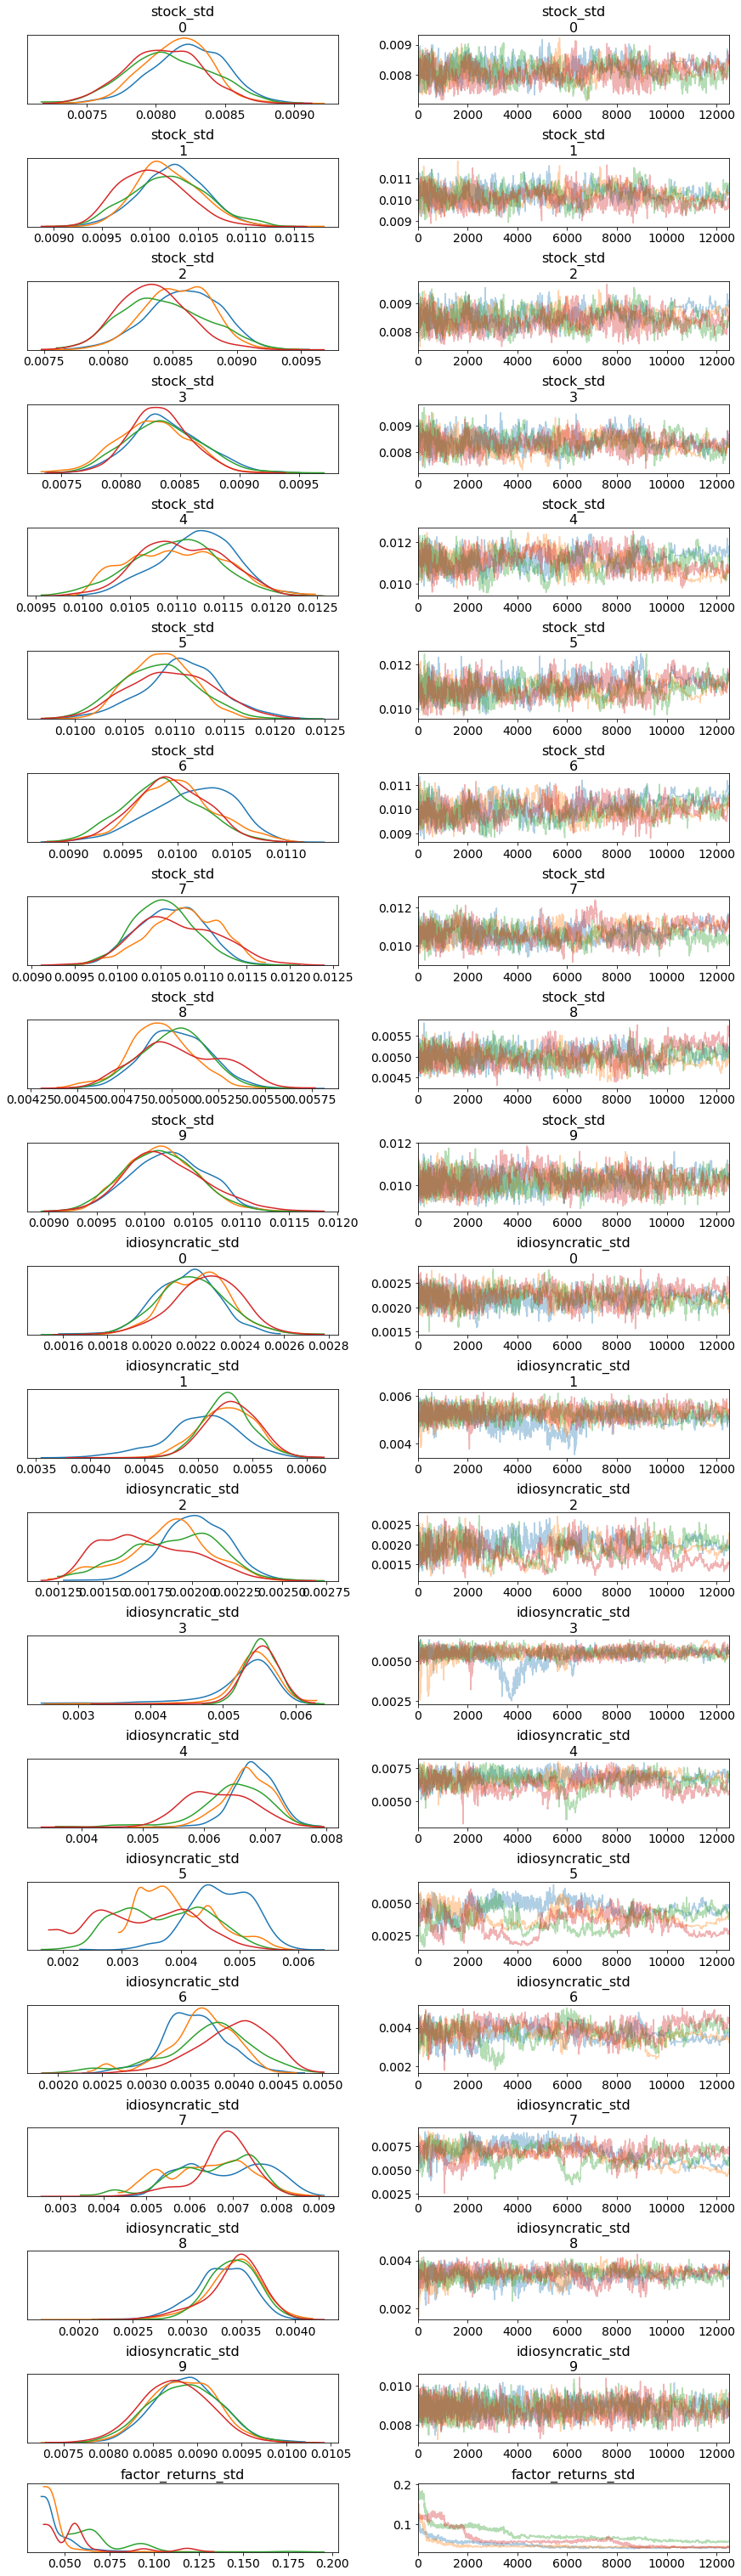

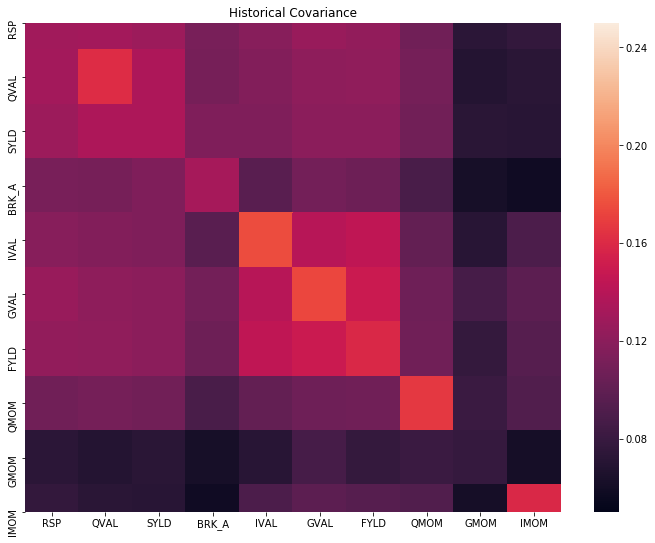

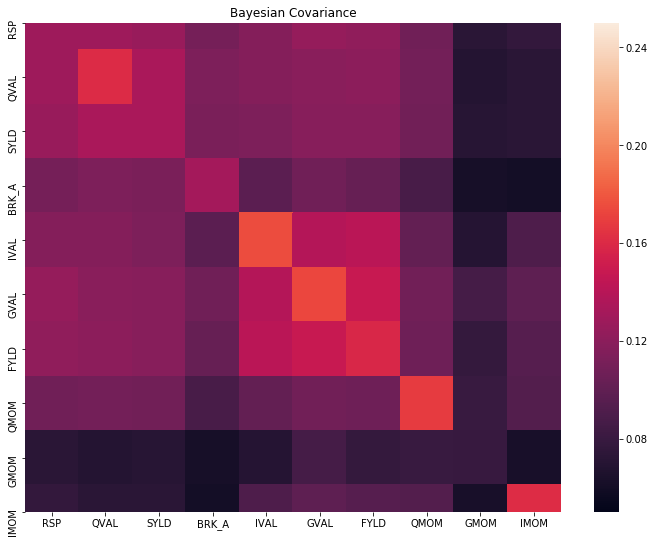

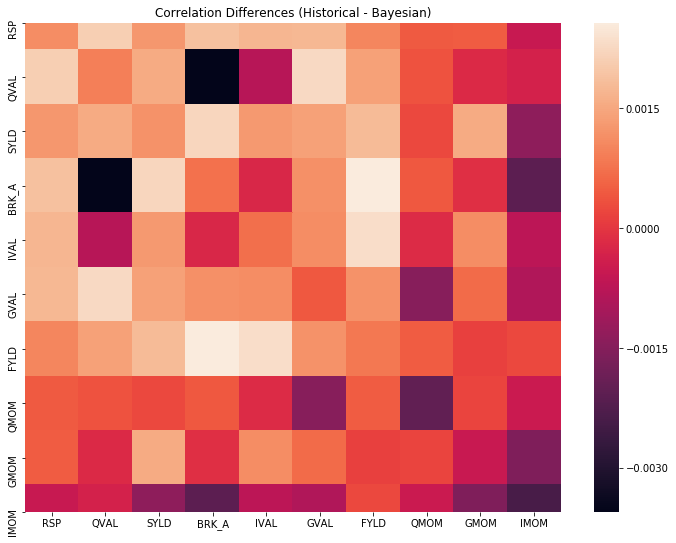

In [38]:
factor_model, factor_trace = prob_factorization(
    dataset     = returns_df,
    n_factors   = 4,
    draws       = 50000,
    sample_init = 'advi',
    verbose     = 1,
    cores       = 4
)

plot_cov(returns_df, factor_trace)